# Makeover Monday: Bike crashes in London

### Import Python tools and Jupyter configuration

In [1]:
%load_ext lab_black

In [2]:
import pandas as pd
import geopandas as gpd
import altair as alt
import altair_latimes as lat
import datetime as dt

/Users/mhustiles/.local/share/virtualenvs/notebooks-xu8v5Vvv/lib/python3.8/site-packages/geopandas/_compat.py:106: UserWarning: The Shapely GEOS version (3.8.0-CAPI-1.13.1 ) is incompatible with the GEOS version PyGEOS was compiled with (3.9.1-CAPI-1.14.2). Conversions between both will be slow.
  warnings.warn(


In [3]:
pd.options.display.max_columns = 100
pd.options.display.max_rows = 100
pd.options.display.max_colwidth = None
alt.data_transformers.disable_max_rows()

DataTransformerRegistry.enable('default')

In [4]:
today = dt.datetime.today().strftime("%Y-%m-%d")

---

In [5]:
# https://data.world/makeovermonday/2021w31/workspace/file?filename=Bike+Collisions.xlsx
src = pd.read_excel("https://query.data.world/s/tfaspfre5yetduocupcyfbhdawcv6y")

In [6]:
src.columns = src.columns.str.lower().str.replace(" ", "", regex=False)

### Dates

In [7]:
src["year"] = src["date"].dt.year.astype(str)
src["weekday"] = src["date"].dt.day_name()
src["monthname"] = src["date"].dt.month_name()
src["monthyear"] = src["date"].dt.strftime("%m-%Y")

### Times

In [8]:
src["date_clean"] = [d.date() for d in src["date"]]

In [9]:
src["hour"] = pd.to_datetime(src["date"]).dt.hour

### Categorize the time of the incident

In [10]:
def categorize_hours(h):
    if (h > 4) and (h <= 8):
        return "5-8am"
    elif (h > 8) and (h <= 12):
        return "9-noon"
    elif (h > 12) and (h <= 16):
        return "1-4pm"
    elif (h > 16) and (h <= 20):
        return "5-8pm"
    elif (h > 20) and (h <= 24):
        return "9-midnight"
    elif h <= 4:
        return "1-4am"

In [11]:
src["time_period"] = src["hour"].apply(categorize_hours)

### Just solo cyclist incidents

In [12]:
src = src[src["casualties"] == "Cyclist"]

---

In [13]:
df = src.copy()

In [14]:
df.drop(["url", "apiurl", "date", "accidentindex", "casualties"], inplace=True, axis=1)

In [15]:
df.rename(columns={"date_clean": "date"}, inplace=True)

In [16]:
df.severity.value_counts()

slight     51707
serious     7396
fatal        188
Name: severity, dtype: int64

---

### Years

In [17]:
years = df.groupby(["year"]).agg({"numberofcasualties": "sum"}).reset_index()

In [18]:
alt.Chart(years).mark_bar().encode(y="numberofcasualties", x="year").properties(
    width=620, height=400
)

alt.Chart(...)

### Wards

In [19]:
wards = df.groupby(["ward", "year"]).agg({"numberofcasualties": "sum"}).reset_index()

### Boroughs

In [20]:
boroughs = (
    df.groupby(["borough", "year"]).agg({"numberofcasualties": "sum"}).reset_index()
)

In [21]:
alt.Chart(boroughs).mark_bar().encode(
    y="numberofcasualties", x="year", facet=alt.Facet("borough", columns=10)
).properties(width=100, height=100)

alt.Chart(...)

---

### Geography

In [22]:
# via https://data.london.gov.uk/dataset/statistical-gis-boundary-files-london &
# https://data.london.gov.uk/dataset/inner-and-outer-london-boundaries-london-plan-consultation-2009

### Wards

In [23]:
wards_geo = gpd.read_file(
    "data/raw/London-wards-2018/London-wards-2018_ESRI/London_Ward.shp"
)

In [24]:
wards_geo.columns = wards_geo.columns.str.lower()

<AxesSubplot:>

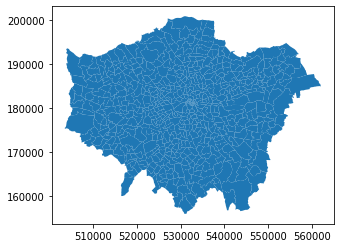

In [25]:
wards_geo.plot()

### Boroughs

In [26]:
boroughs_geo = gpd.read_file(
    "data/raw/statistical-gis-boundaries-london/ESRI/London_Borough_Excluding_MHW.shp"
)

In [27]:
boroughs_geo.columns = boroughs_geo.columns.str.lower()

<AxesSubplot:>

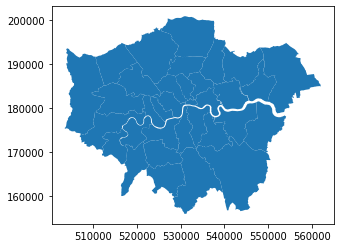

In [28]:
boroughs_geo.plot()

### London city boundary

In [29]:
london_boundaries_geo = gpd.read_file(
    "data/raw/inner-outer-london-shp/lp-consultation-oct-2009-inner-outer-london.shp"
)

In [30]:
london_boundaries_geo.columns = london_boundaries_geo.columns.str.lower()

### Dissolve the inner and outer boundaries

In [31]:
london_geo = london_boundaries_geo.dissolve(by="source")

<AxesSubplot:>

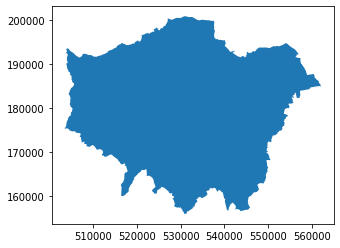

In [32]:
london_geo.plot()

### Inner vs. Outer

In [33]:
inner = london_boundaries_geo[london_boundaries_geo["boundary"] == "Inner London"]

<AxesSubplot:>

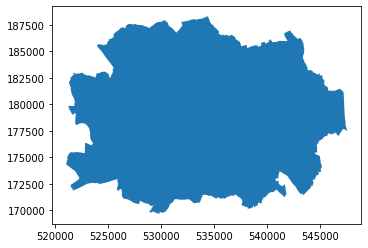

In [34]:
inner.plot()

In [35]:
outer = london_boundaries_geo[london_boundaries_geo["boundary"] == "Outer London"]

<AxesSubplot:>

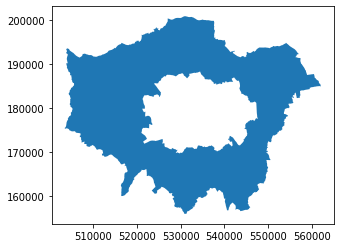

In [36]:
outer.plot()